## Online
### 一、背景介绍  
    1.1 背景
    1.2 问题
    1.3 数据
    1.4 评测
### 二、探索性数据分析  
    2.1 读取店铺信息数据
    2.2 店铺数据详细信息
    2.3 读取支付数据
    2.4 单个商家客流量的走势图
### 三、ARIMA模型  
    3.1 支付记录统计
    3.2 绘制查分图
    3.3 平稳性检验
    3.4 模型定阶
    3.5 模型训练
    3.6 模型预测
    3.7 模型评测
### 四、时间序列加权回归模型  
    4.1 最优常数回归模型  
	4.2 时间加权回归模型  
	4.3 周期、天气因素思考
### 五、回归树模型
	5.1 读取数据
	5.2 特征工程
        5.2.1 数据统计
        5.2.2 缺失数据填补
        5.2.3 数据平滑
    5.3 构造训练样本
    5.4 构造目标变量
	5.5 数据拆分
	5.6 模型构建
    5.7 模型评测
### 六、其他解决方案
	7.1 相似历史片段预测填充法
	7.2 模型融合
### 七、总结

# 回归树模型

### 评测 Evaluation
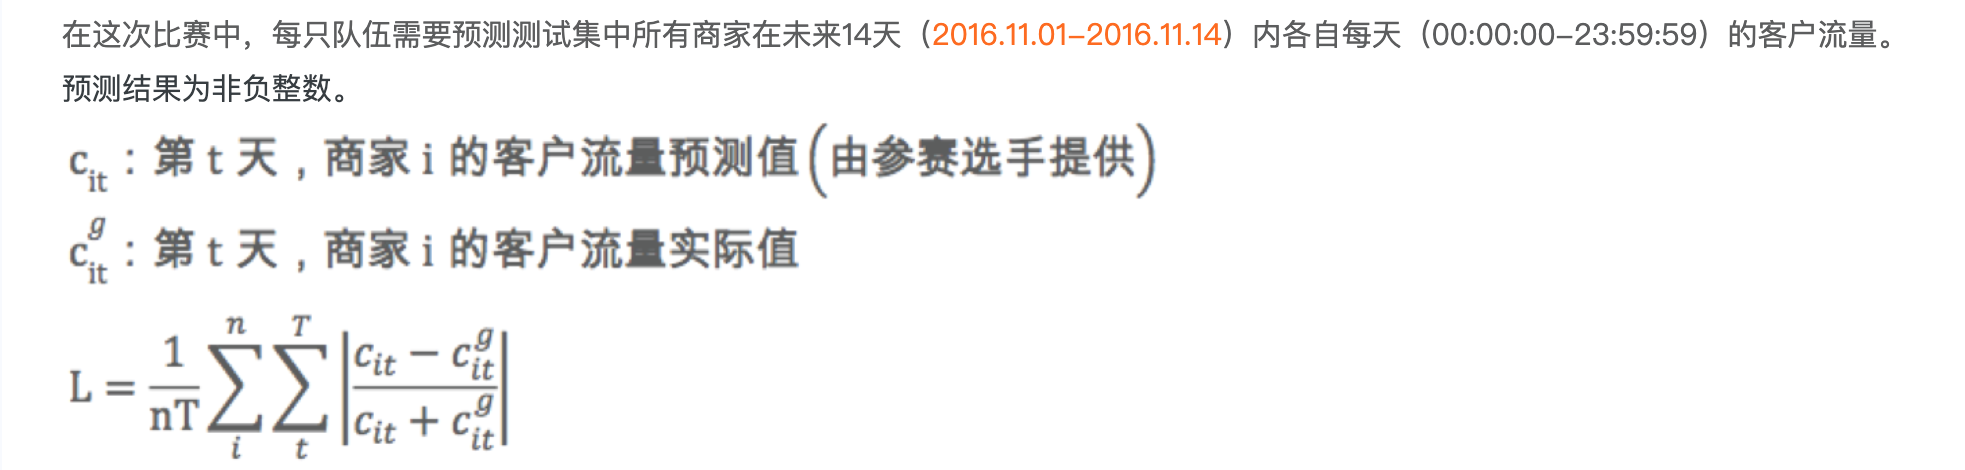

## 5.1 读取数据

In [1]:
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']

In [2]:
shop_info = pd.read_csv('data/dataset/shop_info.txt',
                names=['shop_id','city_name','location_id','per_pay','score','comment_cnt', 'shop_level','cate_1_name','cate_2_name','cate_3_name'])
shop_info.shape , shop_info.head()

((2000, 10),
    shop_id city_name  location_id  per_pay  score  comment_cnt  shop_level  \
 0        1        湖州          885        8    4.0         12.0           2   
 1        2       哈尔滨           64       19    NaN          NaN           1   
 2        3        南昌          774        5    3.0          2.0           0   
 3        4        天津          380       18    NaN          NaN           1   
 4        5        杭州          263        2    2.0          2.0           0   
 
   cate_1_name cate_2_name cate_3_name  
 0          美食        休闲茶饮       饮品/甜点  
 1       超市便利店          超市         NaN  
 2          美食        休闲茶饮          奶茶  
 3       超市便利店          超市         NaN  
 4          美食        休闲食品        生鲜水果  )

In [5]:
user_pay = pd.read_csv('data/dataset/user_pay.txt', names=['user_id','shop_id','time_stamp'] )
user_pay.shape, user_pay.head()

((69674110, 3),     user_id  shop_id           time_stamp
 0  22127870     1862  2015-12-25 17:00:00
 1   3434231     1862  2016-10-05 11:00:00
 2  16955285     1862  2016-02-10 15:00:00
 3  13799128     1862  2016-01-13 14:00:00
 4  13799128     1862  2016-07-05 12:00:00)

In [6]:
user_view = pd.read_csv('data/dataset/user_view.txt', names=['user_id','shop_id','time_stamp'] )
user_view.shape, user_view.head()

((5556715, 3),     user_id  shop_id           time_stamp
 0  13201967     1197  2016-10-21 18:00:00
 1  19461365     1197  2016-06-28 23:00:00
 2  15022321     1197  2016-07-16 19:00:00
 3   5440872     1197  2016-07-15 07:00:00
 4  12594529     1197  2016-08-07 16:00:00)

## 5.2 特征工程

In [7]:
from utils import init_user_pay_count_stat

In [8]:
count_user_pay = init_user_pay_count_stat(user_pay)
count_user_pay.head()

统计支付次数


599275it [00:00, 1071969.63it/s]


缺失数据填补


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:22<00:00, 89.99it/s]


数据缺失平滑处理完毕！


,shop_id,dt,pay_time
0,1,2016-10-31,180.0
1,1,2016-10-30,281.0
2,1,2016-10-29,251.0
3,1,2016-10-28,257.0
4,1,2016-10-27,226.0


In [9]:
from utils import feature_pay_time_rate, feature_pay_time_ma, feature_shop, feature_view_time_ma

In [10]:
from utils import init_user_view_count_stat

count_user_view = init_user_view_count_stat(user_view)

233494it [00:00, 1075915.79it/s]


In [11]:
count_user_view = init_user_view_count_stat(user_view)

233494it [00:00, 878875.31it/s]


## 5.3 构造训练样本

In [12]:

allData = pd.DataFrame()

for shop_id in tqdm(range(1,2001)):
    
    dta = count_user_pay[count_user_pay['shop_id']==shop_id]
    
    fptr = feature_pay_time_rate(dta, 7)
    fptr = fptr[fptr['dt']=='2016-10-24']
    del fptr['dt']
    
    fptm = feature_pay_time_ma(dta)
    fptm = fptm[fptm['dt']=='2016-10-24']
    del fptm['dt']
    
    dta2 = count_user_view[count_user_view['shop_id']==shop_id].sort_values('dt', ascending=False) # 浏览记录数据
    if dta2.shape[0]==0:
        continue
    fvtm = feature_view_time_ma(dta2)
    fvtm = fvtm[fvtm['dt']=='2016-10-24']
    del fvtm['dt']
    
    df = pd.concat([fptr,fptm], axis=1)
    df = pd.concat([df,fvtm], axis=1)
    df['shop_id'] = shop_id
    
    allData = pd.concat([allData, df])
    
featureShop = feature_shop(shop_info)
allData = pd.merge(allData, featureShop, how='left', on='shop_id')


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:04<00:00, 16.06it/s]


In [13]:
allData.shape

(2360, 221)

## 5.4 构造目标变量

In [14]:
test = user_pay[user_pay['dt']>='2016-10-25']
test = test.groupby(['shop_id','dt'])['user_id'].count()

infos = []
for index,freq in tqdm(zip(test.index, test)):
    shop_id, dt = index
    infos.append({
            'shop_id':shop_id,
            'dt':dt,
            'pay_time':freq
        })

test = pd.DataFrame(infos)
test.head()

13961it [00:00, 734778.19it/s]


,shop_id,dt,pay_time
0,1,2016-10-25,255
1,1,2016-10-26,172
2,1,2016-10-27,226
3,1,2016-10-28,257
4,1,2016-10-29,251


In [15]:
y = test.groupby(['shop_id'])['pay_time'].mean()
y = pd.DataFrame( {'shop_id':y.index, 'y':y.values} )

In [16]:
allData = pd.merge(allData,y,how='inner',on='shop_id').fillna(0)

In [17]:

x_new = allData.drop(['y','shop_id'], axis=1)
y_new = allData[['shop_id','y']]


## 5.5 数据拆分

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, 
                                                   test_size=.2, 
                                                   random_state=10)

## 5.6 模型构建

In [19]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [20]:

def evalmape(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = np.abs((y_pred - y_true) / y_true)
    return 'mape',np.mean(err) * 100

params = {
    'objective': 'reg:linear',
    'colsample_bytree': 0.72,
    'max_depth': 8,
    'nthread': 8,
    'seed': 2021,
    'missing':-1
}

## build xgb
xgtrain = xgb.DMatrix( X_train, y_train[['y']] )
gbdt = xgb.train( params, xgtrain, 20, feval=evalmape)

importance = gbdt.get_score()
importance = sorted( importance.items(), key=lambda x:x[1], reverse=True )
importance = pd.DataFrame(importance, columns=['feature', 'score'])

y_test['y-xgb-mape'] = gbdt.predict( xgb.DMatrix( X_test ) )


[17:16:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[17:16:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "missing" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [21]:
y_test.head()

,shop_id,y,y-xgb-mape
168,144,113.000000,113.974869
1705,1454,132.428571,139.371078
2237,1900,51.000000,53.833652
1989,1692,146.857143,271.464203
2082,1769,92.142857,56.938675


##  5.7 模型评测

In [22]:
# 评测函数
def score(vl28, dev):
    L = 0
    for t in dev['pay_time']:
        L += abs(vl28-t)/(vl28+t)
    return L/14

In [23]:
shops_pay_time_v3 = []

for shop_id in set(y_test['shop_id']):
    
    av28 = y_test[y_test['shop_id']==shop_id]['y-xgb-mape'].values[0]
    
    dev = test[test['shop_id']==shop_id]

    shops_pay_time_v3.append({
            'shopid':shop_id,
            'av28':av28,
            'score':score(av28, dev)
        })
shops_pay_time_v3 = pd.DataFrame(shops_pay_time_v3)

In [24]:
np.mean( shops_pay_time_v3['score'] )

0.06360063149315502

### 六、其他解决方案
	6.1 相似历史片段预测填充法
    基于knn，根据官方的测评标准SMAPE作为knn的距离，从历史数据中寻找最相似历史片段进行预测填充。
	6.2 模型融合
    利用不同的算法进行预测，构建基于stacking的模型融合。
### 七、总结
    基于业务数据的具体分析，选择合适的方法。有一个比较有意思的现象，很多场景下，体现是否对业务数据比较熟悉，可以使用简单的模型或者规则，如果能无限逼近复杂模型，则一般能体现出对业务数据背后的思考。